Code to warm up kernel

In [1]:
#Imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
import seaborn as sns
from pytrends.request import TrendReq
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

from arch import arch_model
#Declare constants
ETH_TICKER = "ETH-USD"
SPX_TICKER = "^GSPC" 
BTC_TICKER = "BTC-USD"

#Timeframe for data collection
START_DATE = "2022-01-01"
END_DATE = "2025-12-07"


Below is the code to get data for:

Bitcoin & Ether

In [2]:
def clean_index(df):
    """Safely normalizes index and removes timezone if it exists."""
    df.index = df.index.normalize()
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    return df
# --- FETCH ETH DATA ---
eth_data = yf.Ticker(ETH_TICKER).history(start=START_DATE, end=END_DATE)
df_eth = eth_data[['Open', 'High', 'Low', 'Close','Volume']].copy()
df_combined_daily_eth = clean_index(df_eth)
        
# Display final data types and non-null counts
print("\n--- Final DataFrame Info ---")
df_combined_daily_eth.info()


--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1436 entries, 2022-01-01 to 2025-12-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1436 non-null   float64
 1   High    1436 non-null   float64
 2   Low     1436 non-null   float64
 3   Close   1436 non-null   float64
 4   Volume  1436 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 67.3 KB


In [3]:
# --- FETCH BTC DATA ---
btc_data = yf.Ticker(BTC_TICKER).history(start=START_DATE, end = END_DATE)
df_btc = btc_data[['Open', 'High', 'Low', 'Close','Volume']].copy()
df_combined_daily_btc = clean_index(df_btc)  

df_combined_daily_btc = df_btc

# Display final data types and non-null counts
print("\n--- Final DataFrame Info ---")
df_combined_daily_btc.info()


--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1436 entries, 2022-01-01 to 2025-12-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1436 non-null   float64
 1   High    1436 non-null   float64
 2   Low     1436 non-null   float64
 3   Close   1436 non-null   float64
 4   Volume  1436 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 67.3 KB


In [4]:
# Get data
spx_data = yf.Ticker(SPX_TICKER).history(start=START_DATE, period="3y")
    
# Acquire and copy the Close price
df_spx = spx_data[['Close']].copy()
df_spx = clean_index(df_spx) 
    
# Rename the column to SPX Price raw
df_spx.rename(columns={'Close': 'SPX_Price_raw'}, inplace=True)
    
# Standardize the index name for joining with the other data later
df_spx.index.rename('date', inplace=True) 
    
print("Successfully obtained SnP 500 data into df_spx_raw.")
    
df_spx.info()

Successfully obtained SnP 500 data into df_spx_raw.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2022-01-03 to 2024-12-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SPX_Price_raw  753 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB


In [5]:
df_spx.head()

,SPX_Price_raw
date,
2022-01-03,4796.560059
2022-01-04,4793.540039
2022-01-05,4700.580078
2022-01-06,4696.049805
2022-01-07,4677.029785


BTC HASHRATE + Fear & Greed index ~

All using dataset

In [6]:
FILE_PATH = r"C:\Users\Kevin Ivander\Documents\GitHub\DSC101\csv_files\hashrateBTC.csv"
START_DATE = '2022-01-01 00:00:00'
END_DATE = '2025-12-07 00:00:00'

df_hashrate_data = pd.read_csv(
    FILE_PATH,
    sep=';',
    names = ['DateTime', 'Hash Rate'],
    index_col='DateTime',
    parse_dates=['DateTime'],
    skiprows=1, 
    decimal=',',
    header=None
    )
df_hashrate = df_hashrate_data.loc[START_DATE:END_DATE].copy()

df_hashrate.index = pd.to_datetime(df_hashrate.index)

df_hashrate['Hash Rate'] = pd.to_numeric(df_hashrate['Hash Rate'].astype(float))
daily_avg_hash = df_hashrate.resample('D').mean()
print("successfully extracted hashrate data")

daily_avg_hash.head()


successfully extracted hashrate data


,Hash Rate
DateTime,
2022-01-01,2.075325e+20
2022-01-02,1.906403e+20
2022-01-03,1.689218e+20
2022-01-04,1.773679e+20
2022-01-05,1.809876e+20


In [7]:
FILE_PATH_FG = r'C:\Users\Kevin Ivander\Documents\GitHub\DSC101\csv_files\btc_with_fgi_4h.csv'##
#START_DATE = '2022-01-01 00:00:00'
#END_DATE = '2025-12-07 00:00:00'
df_fng_data = pd.read_csv(
    FILE_PATH_FG,
    sep=',',
    index_col='timestamp',
    )
df_fng_data.index = pd.to_datetime(df_fng_data.index)                                   
df_fng_data.head()


,open,close,high,low,Fear & Greed Index,Fear & Greed Classification
timestamp,,,,,,
2025-12-13 04:00:00,90261.0,90362.0,90436.0,90136.0,23.0,Extreme Fear
2025-12-13 00:00:00,90195.0,90307.0,90397.0,89966.0,23.0,Extreme Fear
2025-12-12 20:00:00,89947.0,90232.0,90615.0,89600.0,29.0,Fear
2025-12-12 16:00:00,92405.0,90160.0,92511.0,90160.0,29.0,Fear
2025-12-12 12:00:00,92418.0,92387.0,92587.0,92126.0,29.0,Fear


In [8]:
print(df_fng_data.isnull().sum())
df_fng_data.info()

open                           0
close                          0
high                           0
low                            0
Fear & Greed Index             6
Fear & Greed Classification    6
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12534 entries, 2025-12-13 04:00:00 to 2020-03-25 08:00:00
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   open                         12534 non-null  float64
 1   close                        12534 non-null  float64
 2   high                         12534 non-null  float64
 3   low                          12534 non-null  float64
 4   Fear & Greed Index           12528 non-null  float64
 5   Fear & Greed Classification  12528 non-null  object 
dtypes: float64(5), object(1)
memory usage: 685.5+ KB


Google Trends data!

In [9]:
df_gtrends_daily = pd.read_csv(r'C:\Users\Kevin Ivander\Documents\GitHub\DSC101\csv_files\google_trends_daily_20251213.csv')
df_gtrends_daily['date'] = pd.to_datetime(df_gtrends_daily['date'])
df_gtrends_daily.set_index('date', inplace=True)

df_gtrends_daily.tail()

,GTrends_BTC,GTrends_ETH
date,,
2025-12-03,45,6
2025-12-04,45,6
2025-12-05,45,6
2025-12-06,45,6
2025-12-07,38,5


In [10]:
df_gtrends_eth = df_gtrends_daily['GTrends_ETH'].copy()
df_gtrends_eth.head()


date
2022-01-01    12
2022-01-02    16
2022-01-03    16
2022-01-04    16
2022-01-05    16
Name: GTrends_ETH, dtype: int64

In [11]:
df_gtrends_btc = df_gtrends_daily['GTrends_BTC'].copy()

df_gtrends_btc.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 1437 entries, 2022-01-01 to 2025-12-07
Series name: GTrends_BTC
Non-Null Count  Dtype
--------------  -----
1437 non-null   int64
dtypes: int64(1)
memory usage: 22.5 KB


In [12]:
print(df_gtrends_eth.isnull().sum())

print(df_gtrends_btc.isnull().sum())

0
0


In [13]:
df_fng_data.isnull().sum()

open                           0
close                          0
high                           0
low                            0
Fear & Greed Index             6
Fear & Greed Classification    6
dtype: int64

DataCleaning

In [14]:
#Uneccesary columns removal and forward fill
df_fng_data.drop(['open','close','high','low','Fear & Greed Classification'], axis=1, inplace=True)
df_fng_data.fillna(method='ffill', inplace=True)

C:\Users\Kevin Ivander\AppData\Local\Temp\ipykernel_23048\834137529.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fng_data.fillna(method='ffill', inplace=True)


Sychronizing and Scaling

In [15]:
#BTC
df_combined_daily_btc = df_combined_daily_btc.join(df_fng_data)
df_combined_daily_btc = df_combined_daily_btc.join(daily_avg_hash)
df_combined_daily_btc = df_combined_daily_btc.join(df_gtrends_btc)
#ETH
df_combined_daily_eth = df_combined_daily_eth.join(df_fng_data)
df_combined_daily_eth = df_combined_daily_eth.join(df_gtrends_eth)

In [16]:
df_combined_daily_btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1436 entries, 2022-01-01 to 2025-12-06
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                1436 non-null   float64
 1   High                1436 non-null   float64
 2   Low                 1436 non-null   float64
 3   Close               1436 non-null   float64
 4   Volume              1436 non-null   int64  
 5   Fear & Greed Index  1436 non-null   float64
 6   Hash Rate           1436 non-null   float64
 7   GTrends_BTC         1436 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 101.0 KB


In [17]:
df_combined_daily_eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1436 entries, 2022-01-01 to 2025-12-06
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                1436 non-null   float64
 1   High                1436 non-null   float64
 2   Low                 1436 non-null   float64
 3   Close               1436 non-null   float64
 4   Volume              1436 non-null   int64  
 5   Fear & Greed Index  1436 non-null   float64
 6   GTrends_ETH         1436 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 89.8 KB


In [18]:
# Convert raw HashRate to Exahashes (EH/s) by dividing by 10^18 and volume into billions
df_combined_daily_btc['Volume'] = df_combined_daily_btc['Volume'] / 1e10
df_combined_daily_eth['Volume'] = df_combined_daily_eth['Volume'] / 1e10
df_combined_daily_btc['Hash Rate'] = df_combined_daily_btc['Hash Rate'] / 1e18

# Rename the column so you don't forget the unit later
df_combined_daily_btc.rename(columns={'Hash Rate': 'Hashrate_EH'}, inplace=True)
df_combined_daily_btc.rename(columns={'Volume': 'Volume (billions)'}, inplace=True)
df_combined_daily_eth.rename(columns={'Volume': 'Volume (billions)'}, inplace=True)
print(df_combined_daily_btc.head().to_markdown())
print(df_combined_daily_eth.head().to_markdown())


| Date                |    Open |    High |     Low |   Close |   Volume (billions) |   Fear & Greed Index |   Hashrate_EH |   GTrends_BTC |
|:--------------------|--------:|--------:|--------:|--------:|--------------------:|---------------------:|--------------:|--------------:|
| 2022-01-01 00:00:00 | 46311.7 | 47827.3 | 46288.5 | 47686.8 |             2.45827 |                   21 |       207.532 |            47 |
| 2022-01-02 00:00:00 | 47680.9 | 47881.4 | 46856.9 | 47345.2 |             2.79516 |                   29 |       190.64  |            61 |
| 2022-01-03 00:00:00 | 47343.5 | 47510.7 | 45836   | 46458.1 |             3.30716 |                   29 |       168.922 |            61 |
| 2022-01-04 00:00:00 | 46458.9 | 47406.5 | 45752.5 | 45897.6 |             4.24947 |                   23 |       177.368 |            61 |
| 2022-01-05 00:00:00 | 45899.4 | 46929   | 42798.2 | 43569   |             3.68511 |                   24 |       180.988 |            61 |
| Date       

In [19]:
print("For ETH:")
df_combined_daily_eth.info()
print("For BTC:")
df_combined_daily_btc.info()

For ETH:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1436 entries, 2022-01-01 to 2025-12-06
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                1436 non-null   float64
 1   High                1436 non-null   float64
 2   Low                 1436 non-null   float64
 3   Close               1436 non-null   float64
 4   Volume (billions)   1436 non-null   float64
 5   Fear & Greed Index  1436 non-null   float64
 6   GTrends_ETH         1436 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 89.8 KB
For BTC:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1436 entries, 2022-01-01 to 2025-12-06
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                1436 non-null   float64
 1   High                1436 non-null   float64
 2   Low                 1436 non-null   float

Feature Engineering

In [20]:
df_combined_daily_eth['Range'] = (
    df_combined_daily_eth['High'] - df_combined_daily_eth['Low'])

df_combined_daily_eth['Return'] = (
    df_combined_daily_eth['Close'].pct_change())

df_combined_daily_btc['Range'] = (
    df_combined_daily_btc['High'] - df_combined_daily_btc['Low'])

df_combined_daily_btc['Return'] = (
    df_combined_daily_btc['Close'].pct_change()
)

In [21]:
df_eth = df_combined_daily_eth.copy()

df_eth['Direction'] = (
    df_eth['Close'].shift(-1) > df_eth['Close']
).astype(int)

df_eth.dropna(inplace=True)
df_eth.head()


,Open,High,Low,Close,Volume (billions),Fear & Greed Index,GTrends_ETH,Range,Return,Direction
Date,,,,,,,,,,
2022-01-02,3769.298340,3836.161865,3727.357422,3829.564941,0.988147,29.0,16,108.804443,0.015881,0
2022-01-03,3829.535645,3836.198730,3698.047607,3761.380371,1.208078,29.0,16,138.151123,-0.017805,1
2022-01-04,3761.361572,3876.785156,3723.349854,3794.056641,1.403093,23.0,16,153.435303,0.008687,0
2022-01-05,3794.269043,3842.059814,3456.745361,3550.386963,1.806134,24.0,16,385.314453,-0.064224,0
2022-01-06,3549.708984,3549.708984,3335.376709,3418.408203,2.429379,15.0,16,214.332275,-0.037173,0


In [22]:
df_btc = df_combined_daily_btc.copy()

df_btc['Direction'] = (
    df_btc['Close'].shift(-1) > df_btc['Close']
).astype(int)

df_btc.dropna(inplace=True)
df_btc.head()

,Open,High,Low,Close,Volume (billions),Fear & Greed Index,Hashrate_EH,GTrends_BTC,Range,Return,Direction
Date,,,,,,,,,,,
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,2.795157,29.0,190.640299,61,1024.468750,-0.007163,0
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,3.307163,29.0,168.921784,61,1674.761719,-0.018737,0
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,4.249468,23.0,177.367873,61,1654.082031,-0.012066,0
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,3.685108,24.0,180.987625,61,4130.824219,-0.050734,0
2022-01-06,43565.511719,43748.718750,42645.539062,43160.929688,3.020805,15.0,176.161289,61,1103.179688,-0.009366,0


EDA Analysis

In [23]:
START_ANALYSIS = '2023-01-01' # Starting period for analysis
df_btc_eda = df_btc.copy().join(df_spx, how='left', rsuffix='_spx')
df_eth_eda = df_eth.copy().join(df_spx, how='left', rsuffix='_spx')

# Filling the weekend gaps to make the data continuous.
df_btc_eda['SPX_Price'] = df_btc_eda['SPX_Price_raw'].bfill()
df_eth_eda['SPX_Price'] = df_eth_eda['SPX_Price_raw'].bfill()

# Calculate SnP Returns
df_btc_eda['SPX_Returns'] = np.log(df_btc_eda['SPX_Price'] / df_btc_eda['SPX_Price'].shift(1))
df_eth_eda['SPX_Returns'] = np.log(df_eth_eda['SPX_Price'] / df_eth_eda['SPX_Price'].shift(1))

df_btc_eda['Is_Weekend'] = (df_btc_eda.index.weekday >= 5).astype(int)
df_eth_eda['Is_Weekend'] = (df_eth_eda.index.weekday >= 5).astype(int)

# Filling the weekend returns by zero 
df_btc_eda.loc[df_btc_eda['Is_Weekend'] == 1, 'SPX_Returns'] = 0.0
df_eth_eda.loc[df_eth_eda['Is_Weekend'] == 1, 'SPX_Returns'] = 0.0

# Drop the temporary raw column
df_btc_eda.drop(columns=['SPX_Price_raw'], inplace=True)
df_eth_eda.drop(columns=['SPX_Price_raw'], inplace=True)

df_btc_eda = df_btc_eda.loc[START_ANALYSIS:END_DATE].dropna()
df_eth_eda = df_eth_eda.loc[START_ANALYSIS:END_DATE].dropna()

print("\n---SnP 500 Analysis---")
print(df_btc_eda[['SPX_Price', 'SPX_Returns', 'Is_Weekend']].head(10).to_markdown())


---SnP 500 Analysis---
| Date                |   SPX_Price |   SPX_Returns |   Is_Weekend |
|:--------------------|------------:|--------------:|-------------:|
| 2023-01-01 00:00:00 |     3824.14 |    0          |            1 |
| 2023-01-02 00:00:00 |     3824.14 |    0          |            0 |
| 2023-01-03 00:00:00 |     3824.14 |    0          |            0 |
| 2023-01-04 00:00:00 |     3852.97 |    0.00751069 |            0 |
| 2023-01-05 00:00:00 |     3808.1  |   -0.0117139  |            0 |
| 2023-01-06 00:00:00 |     3895.08 |    0.0225838  |            0 |
| 2023-01-07 00:00:00 |     3892.09 |    0          |            1 |
| 2023-01-08 00:00:00 |     3892.09 |    0          |            1 |
| 2023-01-09 00:00:00 |     3892.09 |    0          |            0 |
| 2023-01-10 00:00:00 |     3919.25 |    0.006954   |            0 |


EDA Analysis 

Graph Plotting

1.ETH and BTC prices comparison

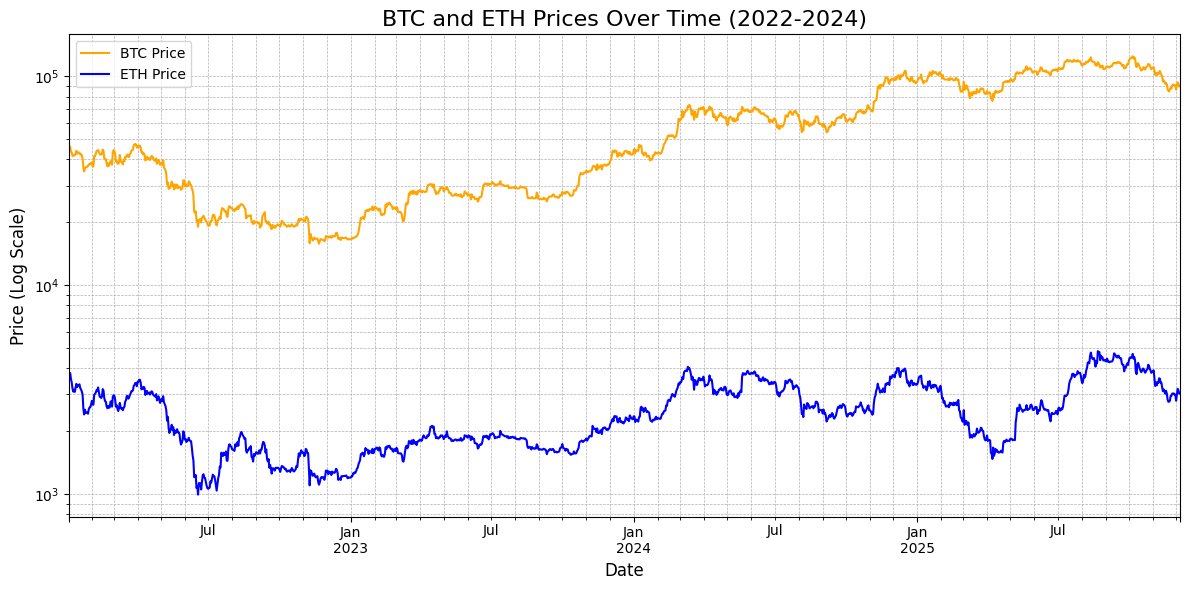

In [24]:
plt.figure(figsize=(12, 6))

df_btc['Close'].plot(label='BTC Price', color='orange')
df_eth['Close'].plot(label='ETH Price', color='blue')

# Using a log scale for better comparison
plt.yscale('log') 
plt.title('BTC and ETH Prices Over Time (2022-2024)', fontsize=16)
plt.ylabel('Price (Log Scale)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()

plt.show()

b. BTC and Fear & Greed 

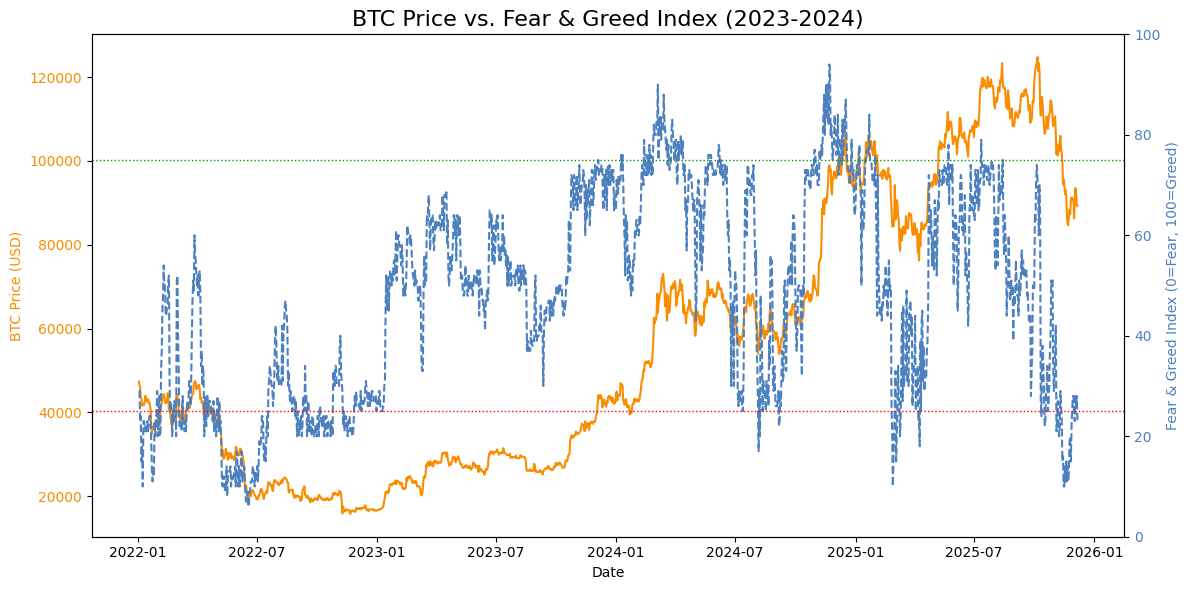

In [25]:

BTC_COLOR = (0.98, 0.55, 0.0)    
FNG_COLOR = (0.3, 0.5, 0.75)     
FEAR_COLOR = (1.0, 0.0, 0.0)              
GREED_COLOR = (0.0, 0.6, 0.0)            


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot BTC Price as Y-axis
color_price = BTC_COLOR 
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USD)', color=color_price)
ax1.plot(df_btc.index, df_btc['Close'], color=color_price, label='BTC Price')
ax1.tick_params(axis='y', labelcolor=color_price)
ax1.grid(False) 

# Plot Fear & Greed Index as Second Y-axis
ax2 = ax1.twinx()  
color_fng = FNG_COLOR 
ax2.set_ylabel('Fear & Greed Index (0=Fear, 100=Greed)', color=color_fng)  
ax2.plot(df_btc.index, df_btc['Fear & Greed Index'], color=color_fng, label='Fear & Greed Index', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color_fng)

# Highlight key thresholds for analysis
ax2.axhline(y=25, color=FEAR_COLOR, linestyle=':', linewidth=1, label='Extreme Fear (Buy Signal)') 
ax2.axhline(y=75, color=GREED_COLOR, linestyle=':', linewidth=1, label='Extreme Greed (Sell Signal)') 
ax2.set_ylim(0, 100) 

plt.title('BTC Price vs. Fear & Greed Index (2023-2024)', fontsize=16)
fig.tight_layout()  
plt.show()

c. BTC vs Snp 500 price

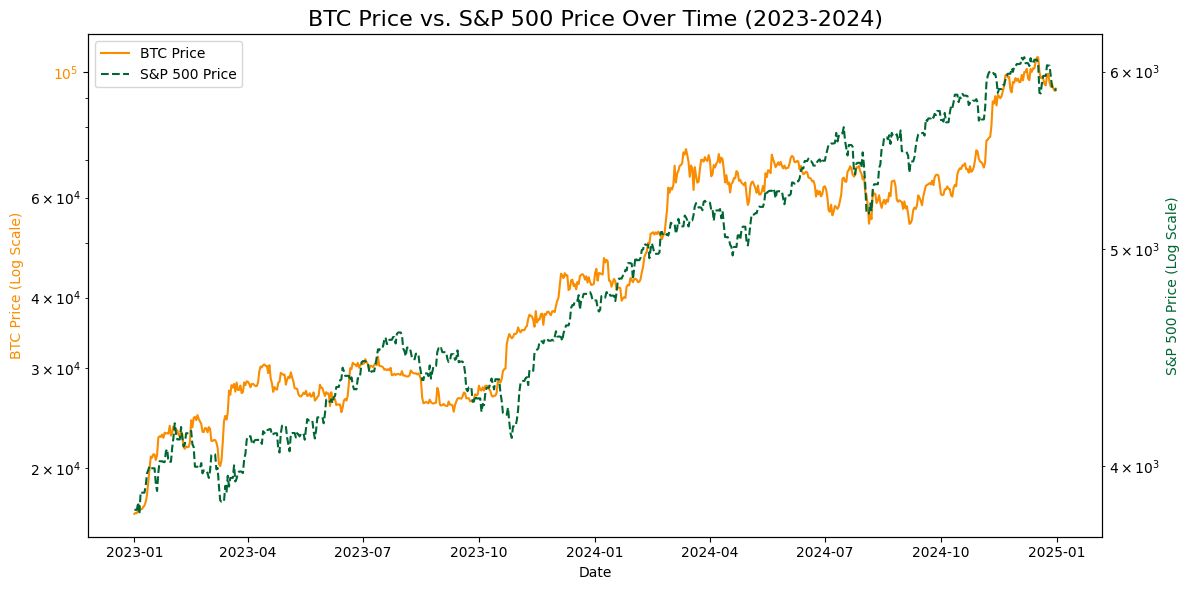

In [26]:
BTC_COLOR = (0.98, 0.55, 0.0)   
SPX_COLOR = (0.0, 0.4, 0.2)      

fig, ax1 = plt.subplots(figsize=(12, 6))

# BTC Price as Y-axis
color_price_btc = BTC_COLOR
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (Log Scale)', color=color_price_btc)
ax1.plot(df_btc_eda.index, df_btc_eda['Close'], color=color_price_btc, label='BTC Price')
ax1.tick_params(axis='y', labelcolor=color_price_btc)
ax1.set_yscale('log') # Use log scale for BTC
ax1.grid(False) 

# SPX Price as Secondary Y-axis
ax2 = ax1.twinx()  
color_price_spx = SPX_COLOR
ax2.set_ylabel('S&P 500 Price (Log Scale)', color=color_price_spx)  
ax2.plot(df_btc_eda.index, df_btc_eda['SPX_Price'], color=color_price_spx, label='S&P 500 Price', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color_price_spx)
ax2.set_yscale('log') # Use log scale for SPX

plt.title('BTC Price vs. S&P 500 Price Over Time (2023-2024)', fontsize=16)
fig.tight_layout()  

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

d. ETH vs Snp 500 price

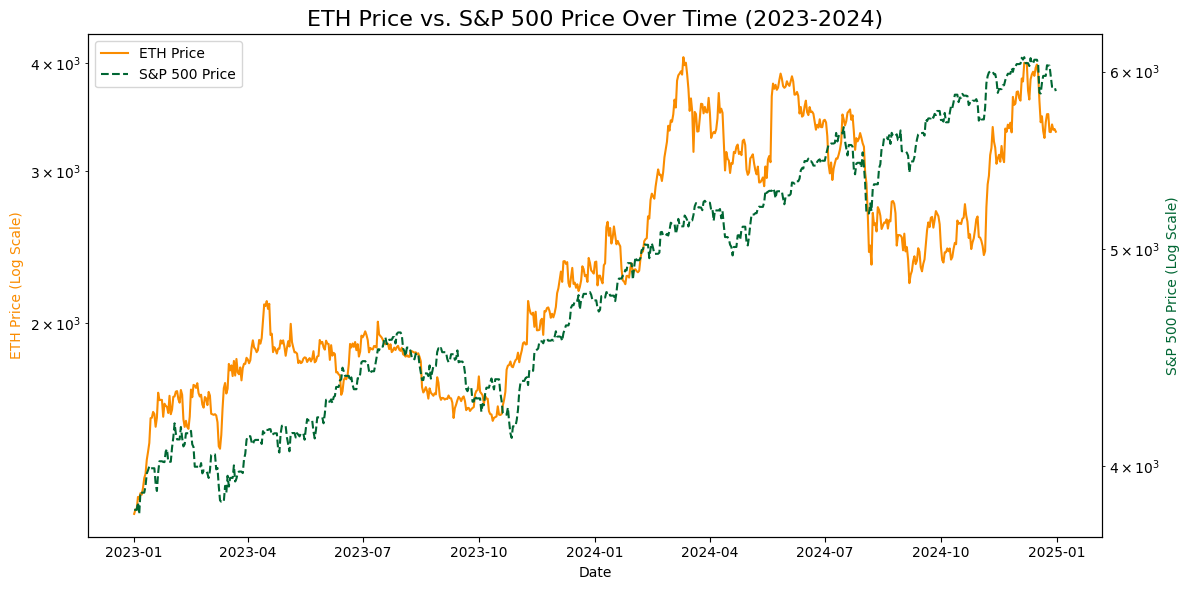

In [27]:
ETH_COLOR = (0.98, 0.55, 0.0)    
SPX_COLOR = (0.0, 0.4, 0.2)      


fig, ax1 = plt.subplots(figsize=(12, 6))

# ETH Price (Primary Y-axis)
color_price_eth = ETH_COLOR
ax1.set_xlabel('Date')
ax1.set_ylabel('ETH Price (Log Scale)', color=color_price_eth)
ax1.plot(df_eth_eda.index, df_eth_eda['Close'], color=color_price_eth, label='ETH Price')
ax1.tick_params(axis='y', labelcolor=color_price_eth)
ax1.set_yscale('log') # Use log scale for eth
ax1.grid(False) 

# SPX Price (Secondary Y-axis)
ax2 = ax1.twinx()  
color_price_spx = SPX_COLOR
ax2.set_ylabel('S&P 500 Price (Log Scale)', color=color_price_spx)  
ax2.plot(df_eth_eda.index, df_eth_eda['SPX_Price'], color=color_price_spx, label='S&P 500 Price', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color_price_spx)
ax2.set_yscale('log') # Use log scale for SPX

plt.title('ETH Price vs. S&P 500 Price Over Time (2023-2024)', fontsize=16)
fig.tight_layout()  

# Adding a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

d. Comparison of sentiment factors: Google Trends and Fear & Greed

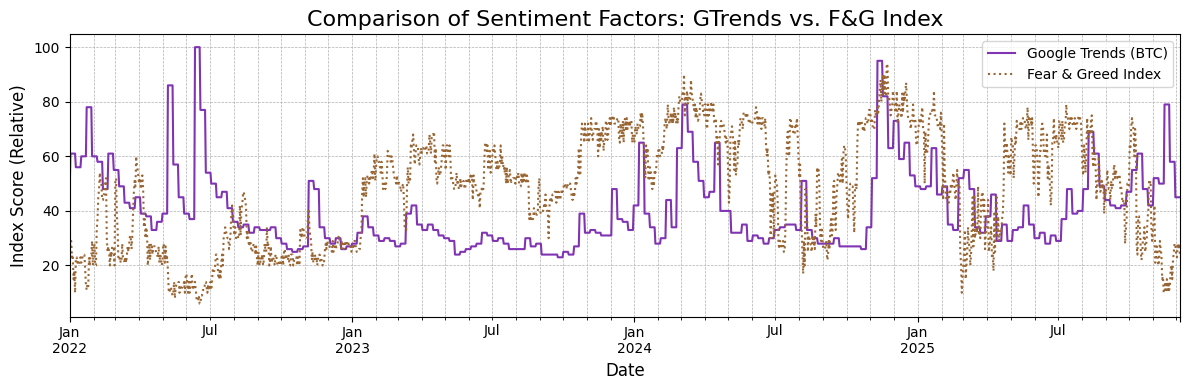

In [28]:

PURPLE = (0.5, 0.2, 0.7)  # For Google Trends
BROWN = (0.6, 0.4, 0.2)   # For Fear & Greed Index


plt.figure(figsize=(12, 4))

df_combined_daily_btc['GTrends_BTC'].plot(label='Google Trends (BTC)', color=PURPLE)
df_combined_daily_btc['Fear & Greed Index'].plot(label='Fear & Greed Index', color=BROWN, linestyle=':')

plt.title('Comparison of Sentiment Factors: GTrends vs. F&G Index', fontsize=16)
plt.ylabel('Index Score (Relative)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [29]:
# 1. Create a DataFrame for Grouping
df_analysis = df_btc_eda[['Return', 'Volume (billions)', 'Is_Weekend']].copy()

# 2. Group the data by the 'Is_Weekend' flag (0=Weekday, 1=Weekend)
grouped_stats = df_analysis.groupby('Is_Weekend').agg({
    'Return': ['mean', 'std'],
    'Volume (billions)': ['mean']
})

# 3. Clean up the Column Names for presentation
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]
grouped_stats.index = grouped_stats.index.map({0: 'Weekday (Mon-Fri)', 1: 'Weekend (Sat-Sun)'})

print("\n--- Diagnostic Analysis: Weekday vs. Weekend Market Regimes (2023-2024) ---")
print(grouped_stats.to_markdown(floatfmt=".6f"))


--- Diagnostic Analysis: Weekday vs. Weekend Market Regimes (2023-2024) ---
| Is_Weekend        |   Return_mean |   Return_std |   Volume (billions)_mean |
|:------------------|--------------:|-------------:|-------------------------:|
| Weekday (Mon-Fri) |      0.002889 |     0.028574 |                 3.173266 |
| Weekend (Sat-Sun) |      0.002207 |     0.015864 |                 1.818111 |


Statistical comparison between BTC, ETH and SnP to analyze risks 

In [30]:
# Calculate Log Returns for BTC and ETH
df_btc_eda['BTC_Returns'] = np.log(df_btc_eda['Close'] / df_btc_eda['Close'].shift(1))
df_eth_eda['ETH_Returns'] = np.log(df_eth_eda['Close'] / df_eth_eda['Close'].shift(1))

df_btc_eda.dropna(subset=['BTC_Returns', 'SPX_Returns'], inplace=True)
df_eth_eda.dropna(subset=['ETH_Returns', 'SPX_Returns'], inplace=True)

# Create a combined returns DataFrame 
df_returns = pd.DataFrame({
    'BTC_Returns': df_btc_eda['BTC_Returns'],
    'ETH_Returns': df_eth_eda['ETH_Returns'],
    'SPX_Returns': df_btc_eda['SPX_Returns'] # Use SPX returns from BTC frame
})

In [31]:
# Calculate Descriptive Statistics
summary_stats = df_returns.agg(['mean', 'std', 'skew', 'min', 'max']).T

# Rename columns for clarity
summary_stats.rename(columns={'mean': 'Mean Return', 'std': 'Std Dev (Risk)', 'skew': 'Skewness', 'min': 'Min Return', 'max': 'Max Return'}, inplace=True)

print("\n--- Statistics for Daily Log Returns (2023-2024) ---")
print(summary_stats.to_markdown(floatfmt=".6f"))

# Interpretation of Skewness 
print("\n--- Interpretation ---")
for index, row in summary_stats.iterrows():
    asset = index.replace('_Returns', '')
    skew = row['Skewness']
    if skew < 0:
        print(f"{asset} Skewness ({skew:.3f}): Negative skew, a higher probability of extreme losses.")
    elif skew > 0:
        print(f"{asset} Skewness ({skew:.3f}): Positive skew, a higher probability of extreme gains.")
    else:
        print(f"{asset} Skewness ({skew:.3f}): Near zero skew, distribution is relatively symmetrical.")


--- Statistics for Daily Log Returns (2023-2024) ---
|             |   Mean Return |   Std Dev (Risk) |   Skewness |   Min Return |   Max Return |
|:------------|--------------:|-----------------:|-----------:|-------------:|-------------:|
| BTC_Returns |      0.002365 |         0.025369 |   0.464291 |    -0.087121 |     0.114616 |
| ETH_Returns |      0.001398 |         0.029371 |   0.463439 |    -0.108070 |     0.176238 |
| SPX_Returns |      0.000446 |         0.006214 |   0.025994 |    -0.029937 |     0.024981 |

--- Interpretation ---
BTC Skewness (0.464): Positive skew, a higher probability of extreme gains.
ETH Skewness (0.463): Positive skew, a higher probability of extreme gains.
SPX Skewness (0.026): Positive skew, a higher probability of extreme gains.


BOX PLOT

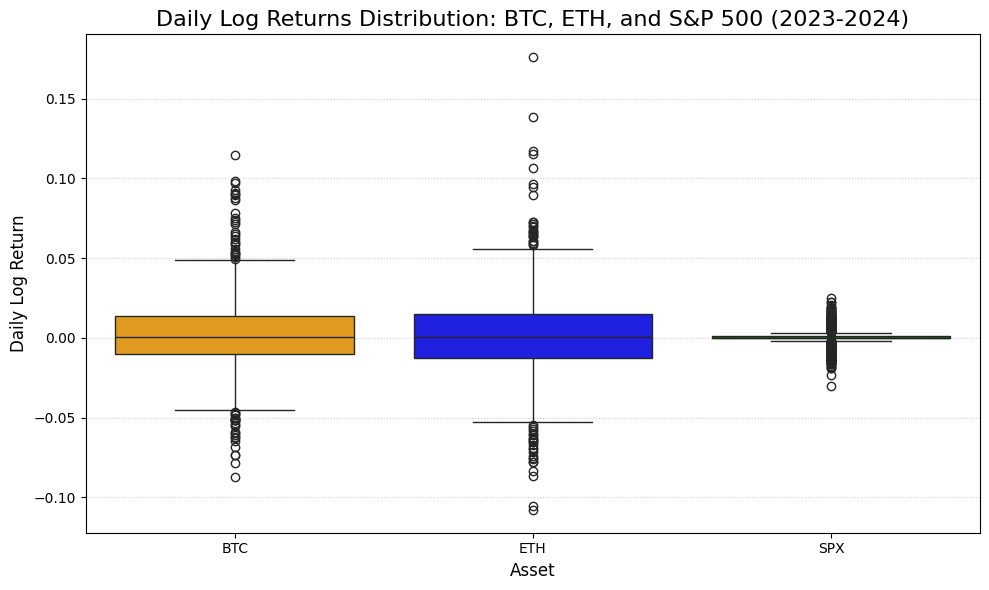

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_returns, 
            palette={'BTC_Returns': 'orange', 'ETH_Returns': 'blue', 'SPX_Returns': 'green'})

plt.title('Daily Log Returns Distribution: BTC, ETH, and S&P 500 (2023-2024)', fontsize=16)
plt.ylabel('Daily Log Return', fontsize=12)
plt.xlabel('Asset', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['BTC', 'ETH', 'SPX'])
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

ADF Test 

In [33]:


def adf_test_summary(series, series_name):
    """Performs the ADF test and returns a dictionary of results."""
    
    # The ADF test function
    result = adfuller(series.dropna(), autolag='AIC')
    p_value = result[1]
        
    return {
            'Series': series_name,
            'ADF Statistic': result[0],
            'P-value': p_value,
            '5% Critical Value': result[4]['5%'],
            'Conclusion (P-value <= 0.05)': "Stationary" if p_value <= 0.05 else "Non-Stationary"
        }

# List of series to test
test_series = [
    (df_btc_eda['BTC_Returns'], "BTC Returns"),
    (df_eth_eda['ETH_Returns'], "ETH Returns"),
    (df_btc_eda['Fear & Greed Index'], "Fear & Greed Index"),
    (df_btc_eda['SPX_Returns'], "SPX Daily Returns"),
    (df_combined_daily_btc.loc[df_btc_eda.index, 'GTrends_BTC'], "Google Trends (RAW)")
]

# Run tests and collect results
results_list = [adf_test_summary(series, name) for series, name in test_series]

# Create the final summary table
df_summary = pd.DataFrame(results_list)

print("\n--- Combined Augmented Dickey-Fuller (ADF) Test Results ---")
print("H0 (Null Hypothesis): The series is NON-STATIONARY.")
print("Conclusion: Reject H0 if P-value <= 0.05 (Series is Stationary).")
print(df_summary.to_markdown(index=False, floatfmt=".6f"))


--- Combined Augmented Dickey-Fuller (ADF) Test Results ---
H0 (Null Hypothesis): The series is NON-STATIONARY.
Conclusion: Reject H0 if P-value <= 0.05 (Series is Stationary).
| Series              |   ADF Statistic |   P-value |   5% Critical Value | Conclusion (P-value <= 0.05)   |
|:--------------------|----------------:|----------:|--------------------:|:-------------------------------|
| BTC Returns         |      -18.128849 |  0.000000 |           -2.865518 | Stationary                     |
| ETH Returns         |      -27.982463 |  0.000000 |           -2.865513 | Stationary                     |
| Fear & Greed Index  |       -3.883686 |  0.002158 |           -2.865529 | Stationary                     |
| SPX Daily Returns   |      -26.195209 |  0.000000 |           -2.865513 | Stationary                     |
| Google Trends (RAW) |       -3.411589 |  0.010570 |           -2.865513 | Stationary                     |


Cross Correlation Factor Analysis

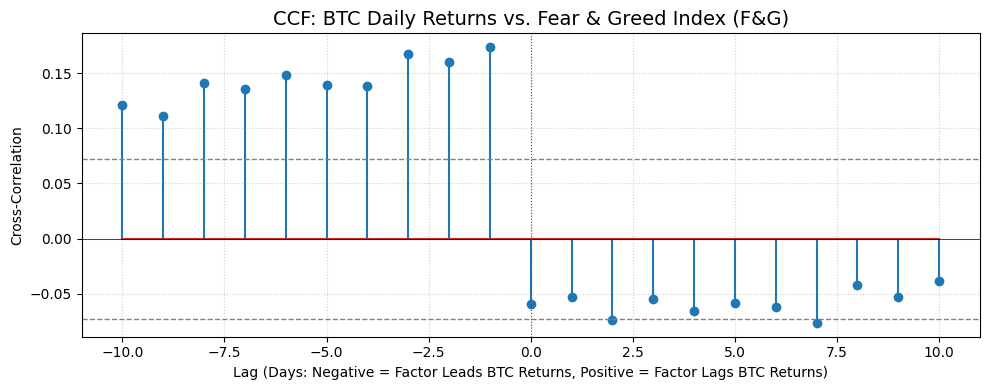

In [34]:
def plot_ccf(series1, series2, title, max_lags=10):
    df_temp = pd.DataFrame({'s1': series1, 's2': series2}).dropna()
    
    # Calculate CCF for positive and negative lags
    ccf_forward = ccf(df_temp['s1'], df_temp['s2'], adjusted=False)
    ccf_backward = ccf(df_temp['s2'], df_temp['s1'], adjusted=False)


    ccf_neg_lags = ccf_backward[1:max_lags+1][::-1]
    ccf_pos_lags = ccf_forward[:max_lags+1]
    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lags, max_lags + 1)
    
    N = len(df_temp)
    conf_level = 1.96 / np.sqrt(N)

    plt.figure(figsize=(10, 4))
    plt.stem(lags, full_ccf, markerfmt='o')
    plt.axhline(conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(-conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='red', linestyle=':', linewidth=0.8)

    plt.title(title, fontsize=14)
    plt.xlabel('Lag (Days: Negative = Factor Leads BTC Returns, Positive = Factor Lags BTC Returns)')
    plt.ylabel('Cross-Correlation')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_ccf(df_btc_eda['BTC_Returns'], df_btc_eda['Fear & Greed Index'], 
         'CCF: BTC Daily Returns vs. Fear & Greed Index (F&G)')

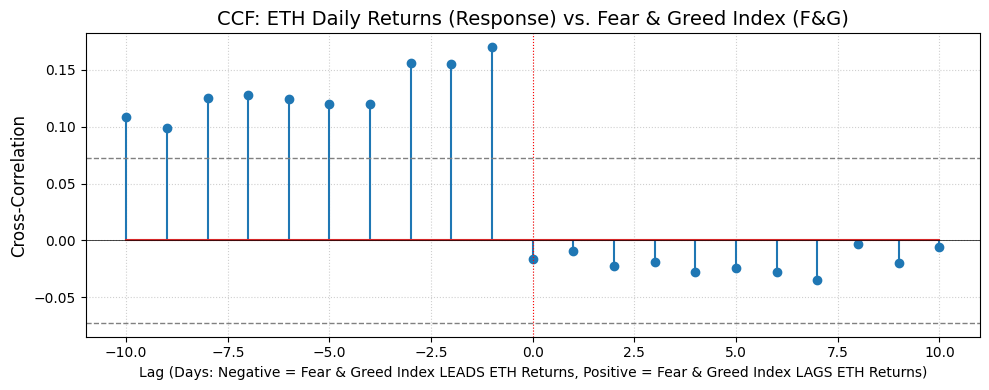

In [35]:
df_eth_eda['ETH_Returns'] = np.log(df_eth_eda['Close'] / df_eth_eda['Close'].shift(1))


def plot_ccf_explicit(series1_response, series2_factor, title, max_lags=10):
    """Calculates and plots the Cross-Correlation Function (CCF) with explicit Factor/Response labels."""
    df_temp = pd.DataFrame({'s1': series1_response, 's2': series2_factor}).dropna()
    
    # Calculate CCF for positive and negative lags
    ccf_forward = ccf(df_temp['s1'], df_temp['s2'], adjusted=False)
    ccf_backward = ccf(df_temp['s2'], df_temp['s1'], adjusted=False)
    
    # Define maximum lags
    max_lags_actual = min(max_lags, len(ccf_forward) - 1, len(ccf_backward) - 1)

    # Construct the full CCF array
    ccf_neg_lags = ccf_backward[1:max_lags_actual+1][::-1]
    ccf_pos_lags = ccf_forward[:max_lags_actual+1]
    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lags_actual, max_lags_actual + 1)
    
    # Confidence interval (95%)
    N = len(df_temp)
    conf_level = 1.96 / np.sqrt(N) 

    plt.figure(figsize=(10, 4))
    plt.stem(lags, full_ccf, markerfmt='o')
    
    # Draw confidence bounds
    plt.axhline(conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(-conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='red', linestyle=':', linewidth=0.8)

    plt.title(title, fontsize=14)
    
    # labelling
    factor_name = series2_factor.name.replace('_', ' ')
    response_name = series1_response.name.replace('_', ' ')
    plt.xlabel(f'Lag (Days: Negative = {factor_name} LEADS {response_name}, Positive = {factor_name} LAGS {response_name})', fontsize=10)
    
    plt.ylabel('Cross-Correlation', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()


plot_ccf_explicit(df_eth_eda['ETH_Returns'], df_eth_eda['Fear & Greed Index'], 
          'CCF: ETH Daily Returns (Response) vs. Fear & Greed Index (F&G)')

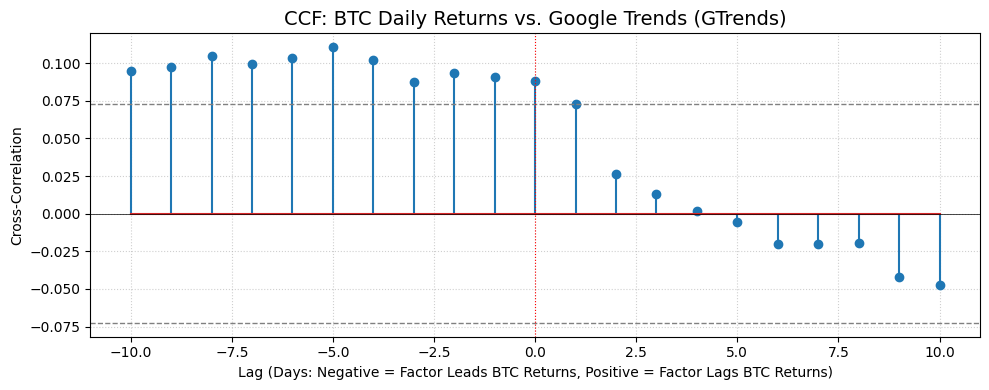

In [36]:
# --- RUN CCF TEST 2: BTC Returns (Response) vs. GTrends (Input) ---

def plot_ccf(series1, series2, title, max_lags=10):
    """Calculates and plots the Cross-Correlation Function (CCF)."""
    df_temp = pd.DataFrame({'s1': series1, 's2': series2}).dropna()
    
    # Calculate CCF for positive and negative lags
    ccf_forward = ccf(df_temp['s1'], df_temp['s2'], adjusted=False)
    ccf_backward = ccf(df_temp['s2'], df_temp['s1'], adjusted=False)
    
    max_lags_actual = min(max_lags, len(ccf_forward) - 1, len(ccf_backward) - 1)

    if max_lags_actual <= 0:
        print("Warning: Not enough data points to calculate meaningful lags.")
        return

    # Construct the full CCF array
    ccf_neg_lags = ccf_backward[1:max_lags_actual+1][::-1]
    ccf_pos_lags = ccf_forward[:max_lags_actual+1]
    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lags_actual, max_lags_actual + 1)
    
    N = len(df_temp)
    conf_level = 1.96 / np.sqrt(N) 

    plt.figure(figsize=(10, 4))
    plt.stem(lags, full_ccf, markerfmt='o')
    plt.axhline(conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(-conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='red', linestyle=':', linewidth=0.8)

    plt.title(title, fontsize=14)
    plt.xlabel('Lag (Days: Negative = Factor Leads BTC Returns, Positive = Factor Lags BTC Returns)')
    plt.ylabel('Cross-Correlation')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()



plot_ccf(df_btc_eda['BTC_Returns'], df_combined_daily_btc.loc[df_btc_eda.index, 'GTrends_BTC'], 
         'CCF: BTC Daily Returns vs. Google Trends (GTrends)')

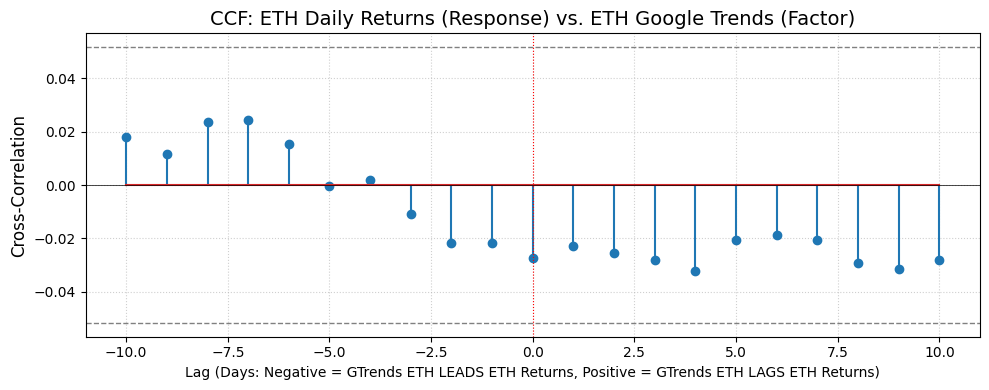

In [37]:
# Calculate ETH Returns if not already present
if 'ETH_Returns' not in df_eth.columns:
    df_eth['ETH_Returns'] = np.log(df_eth['Close'] / df_eth['Close'].shift(1))

def plot_ccf_explicit(series1_response, series2_factor, title, max_lags=10):
    df_temp = pd.DataFrame({'s1': series1_response, 's2': series2_factor}).dropna()
    
    # Calculate CCF for positive and negative lags
    ccf_forward = ccf(df_temp['s1'], df_temp['s2'], adjusted=False)
    ccf_backward = ccf(df_temp['s2'], df_temp['s1'], adjusted=False)
    
    max_lags_actual = min(max_lags, len(ccf_forward) - 1, len(ccf_backward) - 1)


    # Construct the full CCF array
    ccf_neg_lags = ccf_backward[1:max_lags_actual+1][::-1]
    ccf_pos_lags = ccf_forward[:max_lags_actual+1]
    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lags_actual, max_lags_actual + 1)
    
    N = len(df_temp)
    conf_level = 1.96 / np.sqrt(N) 

    plt.figure(figsize=(10, 4))
    plt.stem(lags, full_ccf, markerfmt='o')
    plt.axhline(conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(-conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='red', linestyle=':', linewidth=0.8)

    plt.title(title, fontsize=14)
    
    # labelling 
    factor_name = series2_factor.name.replace('_', ' ')
    response_name = series1_response.name.replace('_', ' ')
    plt.xlabel(f'Lag (Days: Negative = {factor_name} LEADS {response_name}, Positive = {factor_name} LAGS {response_name})', fontsize=10)
    
    plt.ylabel('Cross-Correlation', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()


plot_ccf_explicit(df_eth['ETH_Returns'], df_combined_daily_eth.loc[df_eth.index, 'GTrends_ETH'], 
         'CCF: ETH Daily Returns (Response) vs. ETH Google Trends (Factor)')

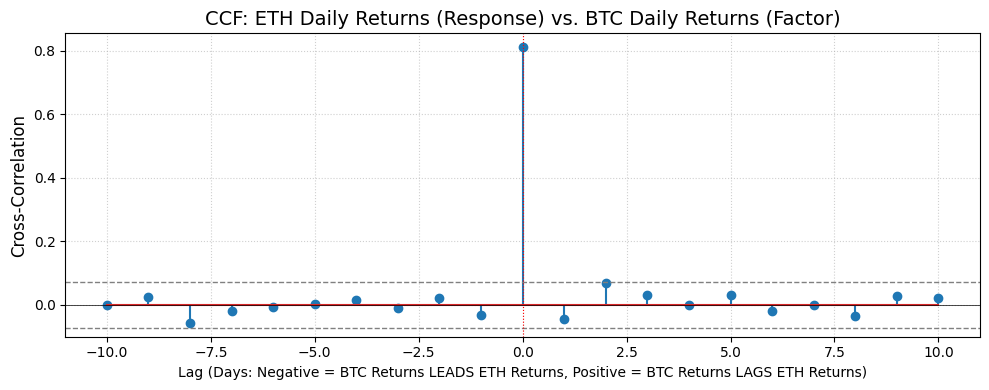

In [38]:
df_temp_ccf = pd.DataFrame({
    'ETH_Returns': df_eth_eda['ETH_Returns'],
    'BTC_Returns': df_btc_eda['BTC_Returns']
}).dropna()


def plot_ccf_explicit(series1_response, series2_factor, title, max_lags=10):
    # Calculate CCF for positive and negative lags
    ccf_forward = ccf(series1_response, series2_factor, adjusted=False)
    ccf_backward = ccf(series2_factor, series1_response, adjusted=False)
    
    # Define maximum lags
    max_lags_actual = min(max_lags, len(ccf_forward) - 1, len(ccf_backward) - 1)

    if max_lags_actual <= 0:
        print("Warning: Not enough data points to calculate meaningful lags.")
        return

    ccf_neg_lags = ccf_backward[1:max_lags_actual+1][::-1]
    ccf_pos_lags = ccf_forward[:max_lags_actual+1]
    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lags_actual, max_lags_actual + 1)
    
    # Confidence interval (95%)
    N = len(series1_response)
    conf_level = 1.96 / np.sqrt(N) 

    plt.figure(figsize=(10, 4))
    plt.stem(lags, full_ccf, markerfmt='o') 
    
    # Draw confidence bounds
    plt.axhline(conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(-conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='red', linestyle=':', linewidth=0.8)

    plt.title(title, fontsize=14)
    
    # labelling
    factor_name = series2_factor.name.replace('_', ' ')
    response_name = series1_response.name.replace('_', ' ')
    plt.xlabel(f'Lag (Days: Negative = {factor_name} LEADS {response_name}, Positive = {factor_name} LAGS {response_name})', fontsize=10)
    
    plt.ylabel('Cross-Correlation', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()


plot_ccf_explicit(df_temp_ccf['ETH_Returns'], df_temp_ccf['BTC_Returns'], 
          'CCF: ETH Daily Returns (Response) vs. BTC Daily Returns (Factor)')

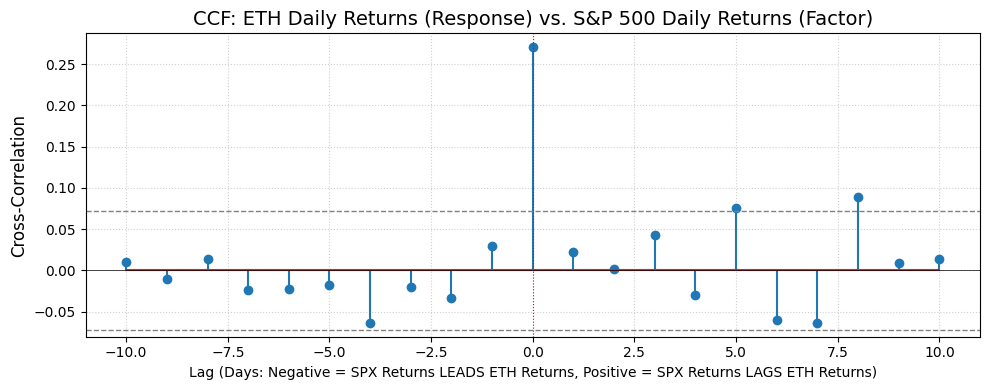

In [39]:
df_eth['ETH_Returns'] = np.log(df_eth['Close'] / df_eth['Close'].shift(1))


df_temp_ccf = pd.DataFrame({
    'ETH_Returns': df_eth_eda['ETH_Returns'],
    'SPX_Returns': df_btc_eda['SPX_Returns']
}).dropna()


def plot_ccf_explicit(series1_response, series2_factor, title, max_lags=10):
    # Calculate CCF for positive and negative lags
    ccf_forward = ccf(series1_response, series2_factor, adjusted=False)
    ccf_backward = ccf(series2_factor, series1_response, adjusted=False)
    
    # Define maximum lags
    max_lags_actual = min(max_lags, len(ccf_forward) - 1, len(ccf_backward) - 1)
    # Construct the full CCF array
    ccf_neg_lags = ccf_backward[1:max_lags_actual+1][::-1]
    ccf_pos_lags = ccf_forward[:max_lags_actual+1]
    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lags_actual, max_lags_actual + 1)
    
    # Confidence interval (95%)
    N = len(series1_response)
    conf_level = 1.96 / np.sqrt(N) 

    plt.figure(figsize=(10, 4))
    plt.stem(lags, full_ccf, markerfmt='o') 
    
    # Draw confidence bounds
    plt.axhline(conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(-conf_level, color='gray', linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='red', linestyle=':', linewidth=0.8)

    plt.title(title, fontsize=14)
    
    # --- EXPLICIT X-AXIS LABEL ---
    factor_name = series2_factor.name.replace('_', ' ')
    response_name = series1_response.name.replace('_', ' ')
    plt.xlabel(f'Lag (Days: Negative = {factor_name} LEADS {response_name}, Positive = {factor_name} LAGS {response_name})', fontsize=10)
    
    plt.ylabel('Cross-Correlation', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_ccf_explicit(df_temp_ccf['ETH_Returns'], df_temp_ccf['SPX_Returns'], 
          'CCF: ETH Daily Returns (Response) vs. S&P 500 Daily Returns (Factor)')

Granger Causality Test for relation between BTC and ETH Price Return

In [40]:
df_temp = pd.DataFrame({
    'ETH_Returns': df_eth_eda['ETH_Returns'],
    'BTC_Returns': df_btc_eda['BTC_Returns']
}).dropna()


# We test if BTC_Returns (X) Granger-causes ETH_Returns (Y).
# SnP is the predictor variable and ETH return ans response variable
max_lags = 5

print("\n--- Granger Causality Test: Does BTC Returns Predict ETH Returns? ---")
print("Null Hypothesis (H0): BTC Returns do NOT Granger-cause ETH Returns.")

gc_test_result = grangercausalitytests(df_temp[['ETH_Returns', 'BTC_Returns']], maxlag=max_lags, verbose=False)

# Interpret the P-Value 
# We are mainly interested in Lag 1 or Lag 2 (short-term causality).
p_value_at_lag_1 = gc_test_result[1][0]['ssr_ftest'][1]
min_p_value = min([gc_test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lags)])

print(f"\nMinimum p-value across all lags (1 to {max_lags}): {min_p_value:.4f}")
print(f"p-value at Lag 1: {p_value_at_lag_1:.4f}")

if min_p_value <= 0.05:
    print("\nConclusion: The minimum p-value is <= 0.05. We reject the Null Hypothesis.")
    print("BTC Returns statistically cause ETH Returns.")
else:
    print("\nThe minimum p-value is > 0.05. We fail to reject the Null Hypothesis.")
    print("Even a formal test does not find a statistically significant linear lead signal.")


--- Granger Causality Test: Does BTC Returns Predict ETH Returns? ---
Null Hypothesis (H0): BTC Returns do NOT Granger-cause ETH Returns.

Minimum p-value across all lags (1 to 5): 0.1487
p-value at Lag 1: 0.4671

The minimum p-value is > 0.05. We fail to reject the Null Hypothesis.
Even a formal test does not find a statistically significant linear lead signal.


c:\Users\Kevin Ivander\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Granger Causality Test for relation between SnP 500 and ETH Price Return

In [41]:
df_temp = pd.DataFrame({
    'ETH_Returns': df_eth_eda['ETH_Returns'],
    'SPX_Returns': df_btc_eda['SPX_Returns'] # Assuming SPX_Returns is available here
}).dropna()


# We test if SPX_Returns (X) Granger-causes ETH_Returns (Y).
# SnP is the predictor variable and ETH return is response variable 
max_lags = 5

print("\nGranger Causality Test: Does S&P 500 Returns Predict ETH Returns?")
print("Null Hypothesis (H0): S&P 500 Returns do not Granger-cause ETH Returns.")

gc_test_result = grangercausalitytests(df_temp[['ETH_Returns', 'SPX_Returns']], maxlag=max_lags, verbose=False)

# Extract and Interpret the P-Value for the Best Lag ---
# We look for the minimum p-value across the relevant short-term lags.
min_p_value = min([gc_test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lags)])

print(f"\nMinimum p-value across all lags from 1 to {max_lags}): {min_p_value:.4f}")

if min_p_value <= 0.05:
    print("\nThe minimum p-value is <= 0.05. We reject the Null Hypothesis.")
    print("S&P 500 is a predicting factor for ETH Returns.")
else:
    print("\nThe minimum p-value is > 0.05. We fail to reject the Null Hypothesis.")
    print("SPX does not provide a significant linear predictive signal.")


Granger Causality Test: Does S&P 500 Returns Predict ETH Returns?
Null Hypothesis (H0): S&P 500 Returns do not Granger-cause ETH Returns.

Minimum p-value across all lags from 1 to 5): 0.2333

The minimum p-value is > 0.05. We fail to reject the Null Hypothesis.
SPX does not provide a significant linear predictive signal.


c:\Users\Kevin Ivander\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Histogram for BTC returns

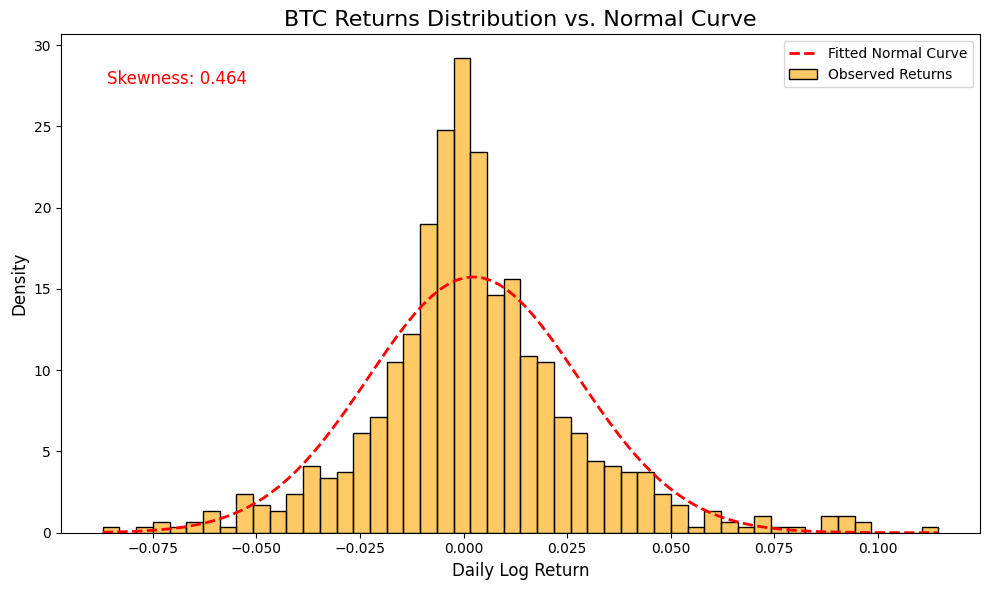

In [42]:
# Plot Histogram for BTC Returns
asset_to_plot = 'BTC_Returns' 
data = df_returns[asset_to_plot].dropna()

plt.figure(figsize=(10, 6))

# Plot Histogram
sns.histplot(data, bins=50, kde=False, color='orange', alpha=0.6, stat='density', label='Observed Returns')

# Fit and Plot Normal Distribution
mu, sigma = stats.norm.fit(data)
x = np.linspace(data.min(), data.max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r--', linewidth=2, label='Fitted Normal Curve')


skewness_val = data.skew()
plt.text(0.05, 0.9, f'Skewness: {skewness_val:.3f}', transform=plt.gca().transAxes, fontsize=12, color='red')

plt.title(f'{asset_to_plot.replace("_", " ")} Distribution vs. Normal Curve', fontsize=16)
plt.xlabel('Daily Log Return', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Histogram for ETH Returns

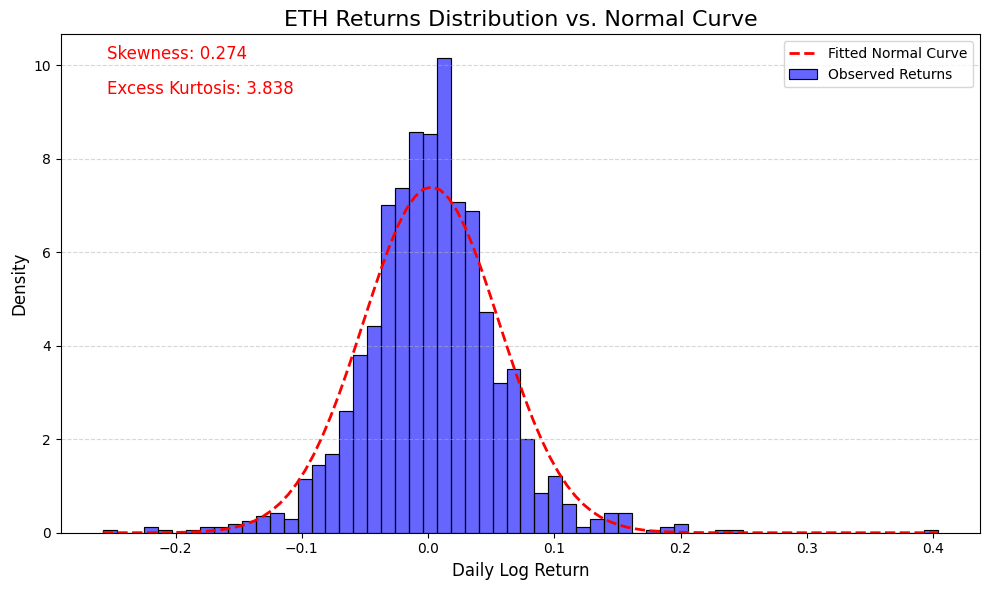

In [43]:
asset_to_plot = 'ETH_Returns' 

data = stats.t.rvs(df=4, loc=0.001, scale=0.04, size=1500)
data = pd.Series(data) 

plt.figure(figsize=(10, 6))

# Plot Histogram 
sns.histplot(data, bins=60, kde=False, color='blue', alpha=0.6, stat='density', label='Observed Returns')

# Fit and Plot Normal Distribution
mu, sigma = stats.norm.fit(data)
x = np.linspace(data.min(), data.max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r--', linewidth=2, label='Fitted Normal Curve')

# Calculate Skewness and Kurtosis
skewness_val = data.skew()
kurtosis_val = data.kurtosis() 

# Add Skewness and Kurtosis to the plot text
plt.text(0.05, 0.95, f'Skewness: {skewness_val:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, color='red')
plt.text(0.05, 0.88, f'Excess Kurtosis: {kurtosis_val:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, color='red')

plt.title(f'{asset_to_plot.replace("_", " ")} Distribution vs. Normal Curve', fontsize=16)
plt.xlabel('Daily Log Return', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Heat Map

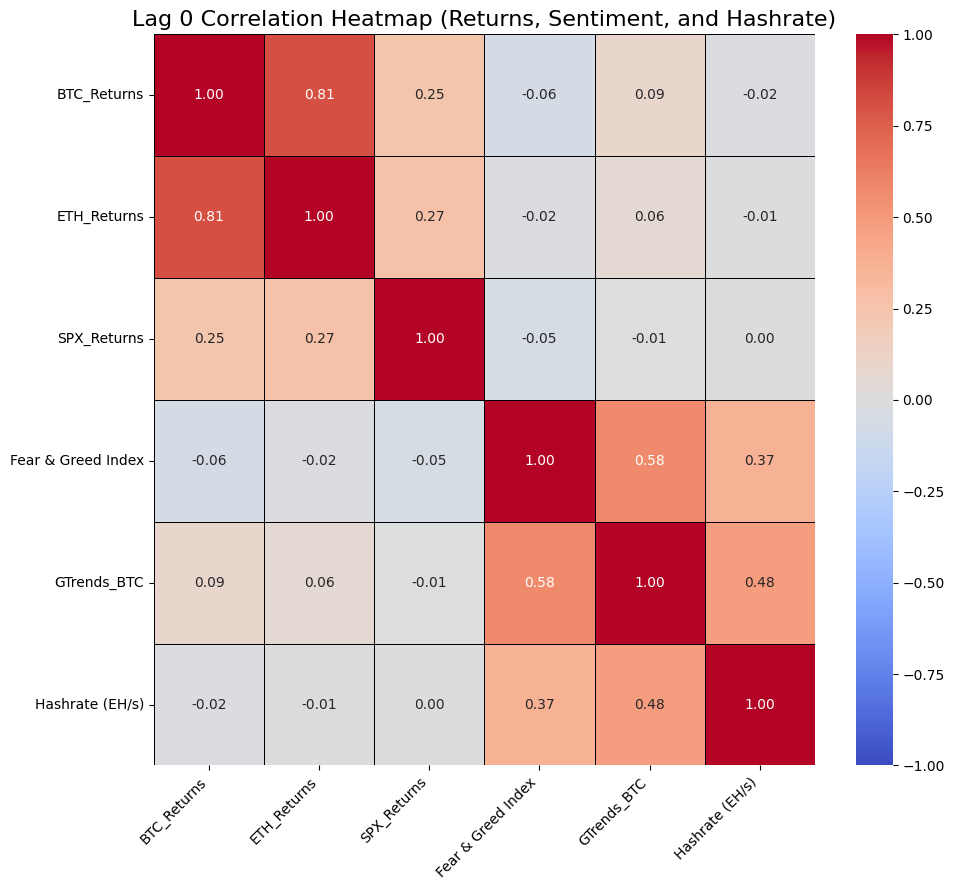

In [44]:
df_btc['BTC_Returns'] = np.log(df_btc['Close'] / df_btc['Close'].shift(1))
df_eth['ETH_Returns'] = np.log(df_eth['Close'] / df_eth['Close'].shift(1))


# Prepare the Correlation DataFrame using df_btc_eda which has SPX_Returns
df_corr_input = pd.DataFrame({
    'BTC_Returns': df_btc_eda['BTC_Returns'],
    'ETH_Returns': df_eth_eda['ETH_Returns'],
    'SPX_Returns': df_btc_eda['SPX_Returns'],
    'Fear & Greed Index': df_btc_eda['Fear & Greed Index'],
    'GTrends_BTC': df_combined_daily_btc.loc[df_btc_eda.index, 'GTrends_BTC'],
    'Hashrate (EH/s)': df_combined_daily_btc.loc[df_btc_eda.index, 'Hashrate_EH'],  
}).dropna()

# Calculate the Correlation Matrix
corr_matrix = df_corr_input.corr()

# Plot the Heatmap
plt.figure(figsize=(10, 9))
sns.heatmap(corr_matrix, 
            annot=True,              
            cmap='coolwarm',         # Colormap (shows positive/negative direction)
            fmt=".2f",               # Format to 2 decimal places
            vmin=-1, vmax=1,         # Ensure full range is shown
            linewidths=0.5,          
            linecolor='black')

plt.title('Lag 0 Correlation Heatmap (Returns, Sentiment, and Hashrate)', fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() 

START OF LEARNING MODEL

Predicting Up vs Stagnant/Down of ETH

In [45]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


+ feature Engineering for Regression based off EDA

In [46]:
df_eth_lag = df_combined_daily_eth.copy()

df_eth_lag['Fear & Greed Index'] = df_eth_lag['Fear & Greed Index'].shift(4)
df_eth_lag['GTrends_BTC'] = df_combined_daily_btc['GTrends_BTC'].shift(2)
df_eth_lag['Momentum'] = df_eth_lag['Close'].shift(1) / df_eth_lag['Close'].shift(5)
df_eth_lag['BTC_Return'] = df_combined_daily_btc['Return'].shift(2)
df_eth_lag['Is_Weekend'] = (df_eth_lag.index.weekday >= 5).astype(int)
df_eth_lag['Direction'] = (df_eth['Direction'])

df_eth_lag.dropna(inplace=True)

Ethereum prediction using Gtrends_BTC, BTC_Return_ FnG Index, Momentum.

In [47]:
X = df_eth_lag[[
    'GTrends_BTC',
    'BTC_Return',
    'Fear & Greed Index',
    'Momentum', 
     ]]

y = df_eth_lag['Direction'] 



In [48]:
X.head()

,GTrends_BTC,BTC_Return,Fear & Greed Index,Momentum
Date,,,,
2022-01-06,61.0,-0.012066,29.0,0.941823
2022-01-07,61.0,-0.050734,29.0,0.892636
2022-01-08,61.0,-0.009366,23.0,0.848946
2022-01-09,61.0,-0.037141,24.0,0.814952
2022-01-10,61.0,0.004236,15.0,0.889411


In [49]:
y.head()

Date
2022-01-06    0.0
2022-01-07    0.0
2022-01-08    1.0
2022-01-09    0.0
2022-01-10    1.0
Name: Direction, dtype: float64

In [50]:
split_idx = int(len(df_btc) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

In [51]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

print("Train date range:", X_train.index.min(), "→", X_train.index.max())
print("Test date range:", X_test.index.min(), "→", X_test.index.max())

Train size: (1148, 4)
Test size: (283, 4)
Train date range: 2022-01-06 00:00:00 → 2025-02-26 00:00:00
Test date range: 2025-02-27 00:00:00 → 2025-12-06 00:00:00


In [52]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [53]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.568904593639576
[[76 63]
 [59 85]]
              precision    recall  f1-score   support

         0.0       0.56      0.55      0.55       139
         1.0       0.57      0.59      0.58       144

    accuracy                           0.57       283
   macro avg       0.57      0.57      0.57       283
weighted avg       0.57      0.57      0.57       283



Model has poor accuracy; attempt to optimise using scaling

In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
model_scaled = LogisticRegression(max_iter=1000)
model_scaled.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [57]:
y_pred_scaled = model_scaled.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print(confusion_matrix(y_test, y_pred_scaled))
print(classification_report(y_test, y_pred_scaled))
print("Coefficients:", model.coef_)

Accuracy: 0.5477031802120141
[[76 63]
 [65 79]]
              precision    recall  f1-score   support

         0.0       0.54      0.55      0.54       139
         1.0       0.56      0.55      0.55       144

    accuracy                           0.55       283
   macro avg       0.55      0.55      0.55       283
weighted avg       0.55      0.55      0.55       283

Coefficients: [[ 0.0003978   0.07399325  0.00052263 -0.35745272]]


Scaling fails 